# 📊 Lojistik Regresyon Performans Değerlendirmesi

Bu notebook, farklı özellik seçim yöntemleriyle oluşturulan veri kümeleri üzerinde Lojistik Regresyon modelinin performansını değerlendirir.

## İçerik
1. Kütüphanelerin Yüklenmesi
2. Veri Kümelerinin Yüklenmesi
3. K-Fold Cross Validation ile Eğitim
4. Aşırı Öğrenme Kontrolü ve İyileştirme
5. Test Değerlendirmesi
6. Sonuç Tablosu
7. Karışıklık Matrisi
8. En Başarılı Yöntemle Optimal Özellik Sayısı Analizi
9. Sonuç ve Yorumlar

---
## 1. Kütüphanelerin Yüklenmesi

In [18]:
# Standart kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Sklearn
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Helper modüllerini içe aktar
from helpers import (
    # Data Loader
    get_all_datasets,
    split_train_test,
    load_dataset,
    split_features_target,
    
    # Model Trainer
    create_logistic_regression_model,
    cross_validate_model,
    detect_overfitting,
    apply_regularization,
    train_final_model,
    
    # Evaluation Metrics
    calculate_metrics,
    create_confusion_matrix,
    get_classification_report,
    
    # Report Generator
    generate_results_table,
    save_results_to_csv,
    generate_markdown_report,
    plot_confusion_matrix,
    save_confusion_matrix_plot,
    get_results_dir
)

# Ayarlar
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

print("✓ Kütüphaneler başarıyla yüklendi!")

✓ Kütüphaneler başarıyla yüklendi!


---
## 2. Veri Kümelerinin Yüklenmesi

In [19]:
# Tüm veri kümelerini yükle
datasets = get_all_datasets()

VERİ KÜMELERİ YÜKLENİYOR

📂 Tüm Özellikler
✓ Veri kümesi yüklendi: processed_dataset.csv
  Boyut: (39644, 59)
  Özellik sayısı: 58
  Sınıf dağılımı: 0 → 18490, 1 → 21154

📂 Filtreleme (Pearson)
✓ Veri kümesi yüklendi: filter_method_selected_dataset.csv
  Boyut: (39644, 16)
  Özellik sayısı: 15
  Sınıf dağılımı: 0 → 18490, 1 → 21154

📂 Sarmalayıcı (RFE)
✓ Veri kümesi yüklendi: wrapper_method_selected_dataset.csv
  Boyut: (39644, 16)
  Özellik sayısı: 15
  Sınıf dağılımı: 0 → 18490, 1 → 21154

📂 Gömülü (Random Forest)
✓ Veri kümesi yüklendi: embedded_method_selected_dataset.csv
  Boyut: (39644, 16)
  Özellik sayısı: 15
  Sınıf dağılımı: 0 → 18490, 1 → 21154

✓ Toplam 4 veri kümesi yüklendi.


In [20]:
# Veri kümelerini eğitim/test olarak böl
print("\n" + "=" * 60)
print("EĞİTİM/TEST BÖLÜMLEMESİ (%80/%20)")
print("=" * 60)

for key, data in datasets.items():
    print(f"\n📂 {data['name']}")
    X_train, X_test, y_train, y_test = split_train_test(
        data['X'], data['y'], 
        test_size=0.2, 
        random_state=42
    )
    
    # Datasets dict'ine ekle
    datasets[key]['X_train'] = X_train
    datasets[key]['X_test'] = X_test
    datasets[key]['y_train'] = y_train
    datasets[key]['y_test'] = y_test


EĞİTİM/TEST BÖLÜMLEMESİ (%80/%20)

📂 Tüm Özellikler
  Eğitim seti: 31715 örnek
  Test seti: 7929 örnek

📂 Filtreleme (Pearson)
  Eğitim seti: 31715 örnek
  Test seti: 7929 örnek

📂 Sarmalayıcı (RFE)
  Eğitim seti: 31715 örnek
  Test seti: 7929 örnek

📂 Gömülü (Random Forest)
  Eğitim seti: 31715 örnek
  Test seti: 7929 örnek


---
## 3. K-Fold Cross Validation ile Eğitim

Her veri kümesi için 5-fold cross validation yapılacak.

In [21]:
# Cross-validation sonuçlarını sakla
cv_results = {}

print("=" * 70)
print("5-FOLD CROSS VALIDATION")
print("=" * 70)

for key, data in datasets.items():
    print(f"\n{'='*60}")
    print(f"📊 {data['name']} ({data['feature_count']} özellik)")
    print("="*60)
    
    # Varsayılan model
    model = create_logistic_regression_model(C=1.0)
    
    # Cross-validation
    cv_result = cross_validate_model(
        model, 
        data['X_train'], 
        data['y_train'], 
        cv=5
    )
    
    cv_results[key] = cv_result
    
    # Sonuçları yazdır
    print(f"\nFold sonuçları:")
    print(f"  Eğitim skorları:    {cv_result['train_scores']}")
    print(f"  Validasyon skorları: {cv_result['val_scores']}")
    print(f"\nOrtalamalar:")
    print(f"  Eğitim:     {cv_result['train_mean']:.4f} (±{cv_result['train_std']:.4f})")
    print(f"  Validasyon: {cv_result['val_mean']:.4f} (±{cv_result['val_std']:.4f})")

5-FOLD CROSS VALIDATION

📊 Tüm Özellikler (58 özellik)

Fold sonuçları:
  Eğitim skorları:    [0.65548636 0.65524988 0.6558805  0.65422513 0.65450102]
  Validasyon skorları: [0.65221504 0.65331862 0.64780073 0.6544222  0.65584108]

Ortalamalar:
  Eğitim:     0.6551 (±0.0006)
  Validasyon: 0.6527 (±0.0027)

📊 Filtreleme (Pearson) (15 özellik)

Fold sonuçları:
  Eğitim skorları:    [0.64330758 0.64311052 0.64460823 0.64208576 0.64141573]
  Validasyon skorları: [0.63786852 0.64338641 0.63424247 0.6468548  0.65221504]

Ortalamalar:
  Eğitim:     0.6429 (±0.0011)
  Validasyon: 0.6429 (±0.0064)

📊 Sarmalayıcı (RFE) (15 özellik)

Fold sonuçları:
  Eğitim skorları:    [0.64638184 0.64468706 0.64823427 0.64555415 0.64697304]
  Validasyon skorları: [0.64811603 0.65363393 0.6355037  0.64764307 0.64401703]

Ortalamalar:
  Eğitim:     0.6464 (±0.0012)
  Validasyon: 0.6458 (±0.0060)

📊 Gömülü (Random Forest) (15 özellik)

Fold sonuçları:
  Eğitim skorları:    [0.62628094 0.62533501 0.62801513 0.6275

---
## 4. Aşırı Öğrenme Kontrolü ve İyileştirme

Eğitim ve validasyon skorları arasındaki fark %5'ten büyükse aşırı öğrenme tespit edilmiş kabul edilir ve regularization uygulanır.

In [22]:
# Aşırı öğrenme kontrolü ve iyileştirme
overfitting_info = {}
final_models = {}

print("=" * 70)
print("AŞIRI ÖĞRENME KONTROLÜ VE İYİLEŞTİRME")
print("=" * 70)

for key, data in datasets.items():
    print(f"\n{'='*60}")
    print(f"🔍 {data['name']}")
    print("="*60)
    
    cv_result = cv_results[key]
    
    # Aşırı öğrenme tespiti
    is_overfitting, gap = detect_overfitting(
        cv_result['train_scores'],
        cv_result['val_scores'],
        threshold=0.05
    )
    
    overfitting_info[data['name']] = {
        'detected': is_overfitting,
        'gap': gap
    }
    
    if is_overfitting:
        print(f"⚠️ Aşırı öğrenme tespit edildi! (Fark: {gap:.4f})")
        
        # Regularization uygula
        best_model, reg_info = apply_regularization(
            data['X_train'], 
            data['y_train'],
            cv=5
        )
        
        final_models[key] = {
            'model': best_model,
            'C': reg_info['best_C'],
            'cv_results': reg_info['cv_results']
        }
        
        overfitting_info[data['name']]['best_C'] = reg_info['best_C']
        
    else:
        print(f"✓ Aşırı öğrenme yok. (Fark: {gap:.4f})")
        
        final_models[key] = {
            'model': create_logistic_regression_model(C=1.0),
            'C': 1.0,
            'cv_results': cv_result
        }

AŞIRI ÖĞRENME KONTROLÜ VE İYİLEŞTİRME

🔍 Tüm Özellikler
✓ Aşırı öğrenme yok. (Fark: 0.0023)

🔍 Filtreleme (Pearson)
✓ Aşırı öğrenme yok. (Fark: -0.0000)

🔍 Sarmalayıcı (RFE)
✓ Aşırı öğrenme yok. (Fark: 0.0006)

🔍 Gömülü (Random Forest)
✓ Aşırı öğrenme yok. (Fark: 0.0014)


In [23]:
# Aşırı öğrenme özeti
print("\n" + "=" * 60)
print("AŞIRI ÖĞRENME ÖZETİ")
print("=" * 60)

overfitting_df = pd.DataFrame([
    {
        'Yöntem': method,
        'Aşırı Öğrenme': '⚠️ Evet' if info['detected'] else '✅ Hayır',
        'Eğitim-Validasyon Farkı': f"{info['gap']:.4f}",
        'Uygulanan C': info.get('best_C', 1.0)
    }
    for method, info in overfitting_info.items()
])

display(overfitting_df)


AŞIRI ÖĞRENME ÖZETİ


,Yöntem,Aşırı Öğrenme,Eğitim-Validasyon Farkı,Uygulanan C
0,Tüm Özellikler,✅ Hayır,0.0023,1.0
1,Filtreleme (Pearson),✅ Hayır,-0.0000,1.0
2,Sarmalayıcı (RFE),✅ Hayır,0.0006,1.0
3,Gömülü (Random Forest),✅ Hayır,0.0014,1.0


---
## 5. Test Değerlendirmesi

%20 test seti üzerinde final modelleri değerlendirilecek.

In [24]:
# Final model eğitimi ve test değerlendirmesi
results = {}

print("=" * 70)
print("FINAL MODEL EĞİTİMİ VE TEST DEĞERLENDİRMESİ")
print("=" * 70)

for key, data in datasets.items():
    print(f"\n{'='*60}")
    print(f"🎯 {data['name']}")
    print("="*60)
    
    model_info = final_models[key]
    
    # Final modeli eğit
    trained_model, scaler, training_time = train_final_model(
        model_info['model'],
        data['X_train'],
        data['y_train']
    )
    
    # Test seti üzerinde tahmin
    X_test_scaled = scaler.transform(data['X_test'])
    y_pred = trained_model.predict(X_test_scaled)
    
    # Metrikleri hesapla
    metrics = calculate_metrics(data['y_test'], y_pred)
    
    # Sonuçları sakla
    results[key] = {
        'name': data['name'],
        'feature_count': data['feature_count'],
        'accuracy': metrics['accuracy'],
        'f1_score': metrics['f1_score'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'training_time': training_time,
        'C': model_info['C'],
        'model': trained_model,
        'scaler': scaler,
        'y_pred': y_pred,
        'y_test': data['y_test']
    }
    
    # Sonuçları yazdır
    print(f"\n📊 Test Sonuçları:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"  F1-Score:  {metrics['f1_score']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  C değeri:  {model_info['C']}")

FINAL MODEL EĞİTİMİ VE TEST DEĞERLENDİRMESİ

🎯 Tüm Özellikler
  Eğitim süresi: 0.4291 saniye

📊 Test Sonuçları:
  Accuracy:  0.6552 (65.52%)
  F1-Score:  0.6544
  Precision: 0.6544
  Recall:    0.6552
  C değeri:  1.0

🎯 Filtreleme (Pearson)
  Eğitim süresi: 0.0481 saniye

📊 Test Sonuçları:
  Accuracy:  0.6431 (64.31%)
  F1-Score:  0.6413
  Precision: 0.6421
  Recall:    0.6431
  C değeri:  1.0

🎯 Sarmalayıcı (RFE)
  Eğitim süresi: 0.0992 saniye

📊 Test Sonuçları:
  Accuracy:  0.6510 (65.10%)
  F1-Score:  0.6502
  Precision: 0.6502
  Recall:    0.6510
  C değeri:  1.0

🎯 Gömülü (Random Forest)
  Eğitim süresi: 0.0546 saniye

📊 Test Sonuçları:
  Accuracy:  0.6278 (62.78%)
  F1-Score:  0.6253
  Precision: 0.6266
  Recall:    0.6278
  C değeri:  1.0


---
## 6. Sonuç Tablosu

In [25]:
# Sonuç tablosu oluştur (TÜM YÖNTEMLER DAHİL)
results_df = generate_results_table(results)

print("\n" + "=" * 80)
print("SONUÇ TABLOSU")
print("=" * 80)

display(results_df)


SONUÇ TABLOSU


,Yöntem,Özellik Sayısı,Doğruluk (Accuracy),F1-Skoru,Eğitim Süresi (s),C (Regularization)
0,Tüm Özellikler,58,0.6552,0.6544,0.4291,1.0
1,Filtreleme (Pearson),15,0.6431,0.6413,0.0481,1.0
2,Sarmalayıcı (RFE),15,0.6510,0.6502,0.0992,1.0
3,Gömülü (Random Forest),15,0.6278,0.6253,0.0546,1.0


In [26]:
# En başarılı ÖZELLIK SEÇIM yöntemi bul (Tüm Özellikler HARİÇ)
# Not: Sadece yöntem seçiminde hariç tutuluyor, kaydetme/görselleştirmede dahil
feature_selection_results = {k: v for k, v in results.items() if k != 'all_features'}

best_method_key = max(feature_selection_results.keys(), key=lambda k: feature_selection_results[k]['accuracy'])
best_result = feature_selection_results[best_method_key]

print(f"\n🏆 En Başarılı Özellik Seçim Yöntemi: {best_result['name']}")
print(f"   Accuracy: {best_result['accuracy']:.4f}")
print(f"   F1-Score: {best_result['f1_score']:.4f}")


🏆 En Başarılı Özellik Seçim Yöntemi: Sarmalayıcı (RFE)
   Accuracy: 0.6510
   F1-Score: 0.6502


In [27]:
# Sonuçları CSV'ye kaydet (TÜM YÖNTEMLER DAHİL)
save_results_to_csv(results, "logistic_regression_results.csv")

✓ Sonuçlar kaydedildi: c:\Users\kayra\OneDrive\Üniversite\Dersler\Doktora\Dönem 1\Makine Öğrenmesi\ödev2\kodlar\evaluate_performance\helpers\..\results\logistic_regression_results.csv


'c:\\Users\\kayra\\OneDrive\\Üniversite\\Dersler\\Doktora\\Dönem 1\\Makine Öğrenmesi\\ödev2\\kodlar\\evaluate_performance\\helpers\\..\\results\\logistic_regression_results.csv'

---
## 7. Karışıklık Matrisi

En başarılı özellik seçim yöntemi için karışıklık matrisi görselleştirilecek.


📋 Karışıklık Matrisi - Sarmalayıcı (RFE)

[[2217 1481]
 [1286 2945]]


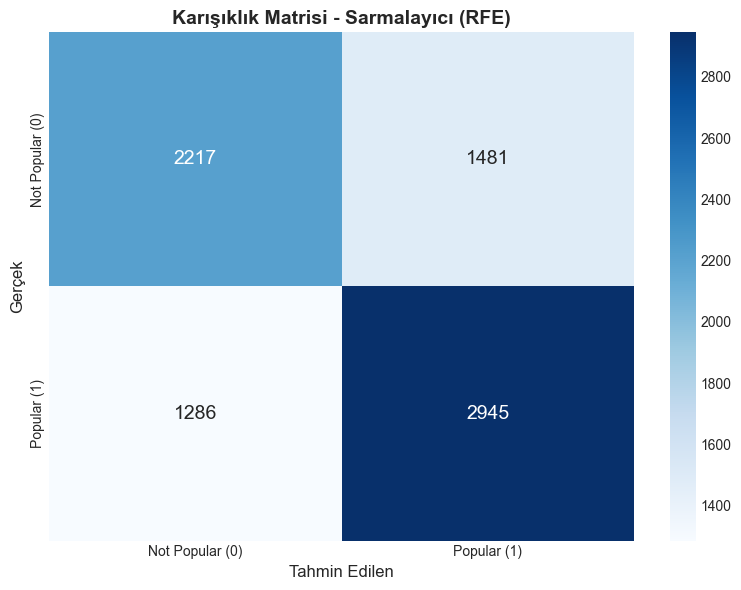

In [28]:
# En başarılı özellik seçim yöntemi için karışıklık matrisi
cm = create_confusion_matrix(best_result['y_test'], best_result['y_pred'])

print(f"\n📋 Karışıklık Matrisi - {best_result['name']}")
print("=" * 50)
print(f"\n{cm}")

# Görselleştir
fig = plot_confusion_matrix(
    cm, 
    title=f"Karışıklık Matrisi - {best_result['name']}"
)
plt.show()

In [29]:
# Karışıklık matrisini kaydet
save_confusion_matrix_plot(
    cm, 
    filename="best_method_confusion_matrix.png",
    title=f"Karışıklık Matrisi - {best_result['name']}"
)

✓ Karışıklık matrisi kaydedildi: c:\Users\kayra\OneDrive\Üniversite\Dersler\Doktora\Dönem 1\Makine Öğrenmesi\ödev2\kodlar\evaluate_performance\helpers\..\results\best_method_confusion_matrix.png


'c:\\Users\\kayra\\OneDrive\\Üniversite\\Dersler\\Doktora\\Dönem 1\\Makine Öğrenmesi\\ödev2\\kodlar\\evaluate_performance\\helpers\\..\\results\\best_method_confusion_matrix.png'

In [30]:
# Detaylı sınıflandırma raporu
print(f"\n📊 Sınıflandırma Raporu - {best_result['name']}")
print("=" * 60)
print(get_classification_report(best_result['y_test'], best_result['y_pred']))


📊 Sınıflandırma Raporu - Sarmalayıcı (RFE)
                 precision    recall  f1-score   support

Not Popular (0)       0.63      0.60      0.62      3698
    Popular (1)       0.67      0.70      0.68      4231

       accuracy                           0.65      7929
      macro avg       0.65      0.65      0.65      7929
   weighted avg       0.65      0.65      0.65      7929



### Tüm Yöntemler İçin Karışıklık Matrisleri

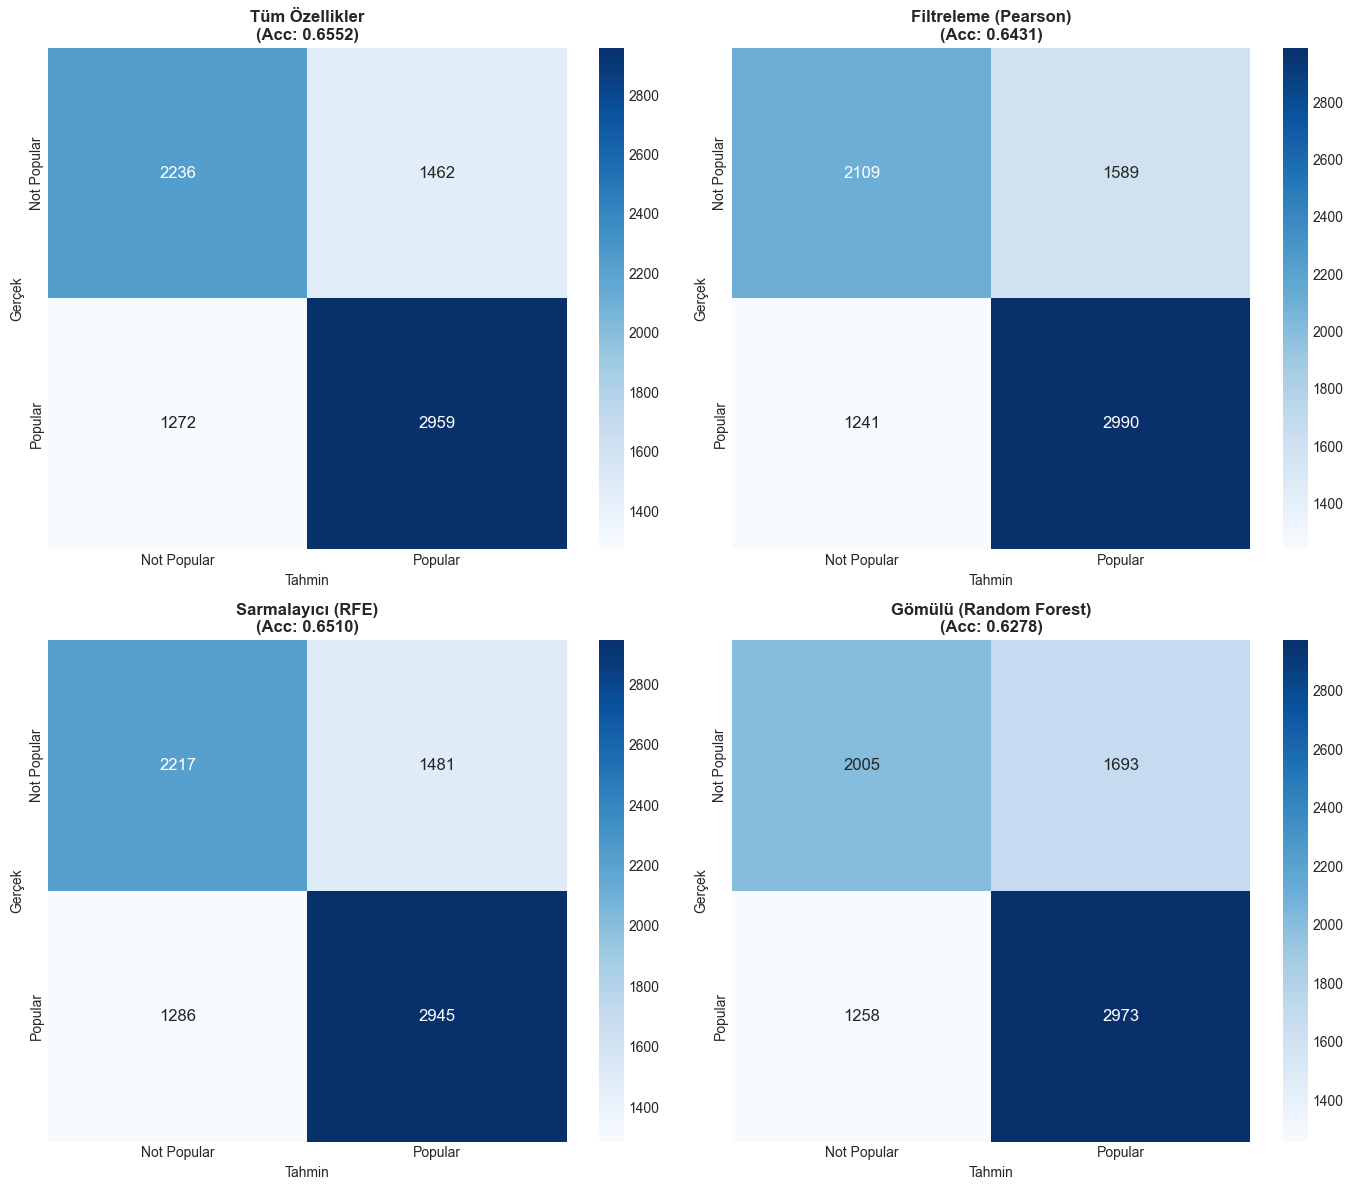


✓ Tüm karışıklık matrisleri kaydedildi.


In [31]:
# TÜM yöntemler için karışıklık matrisleri (Tüm Özellikler DAHİL)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (key, result) in enumerate(results.items()):
    cm = create_confusion_matrix(result['y_test'], result['y_pred'])
    
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=['Not Popular', 'Popular'],
        yticklabels=['Not Popular', 'Popular'],
        ax=axes[idx],
        annot_kws={'size': 12}
    )
    
    axes[idx].set_title(f"{result['name']}\n(Acc: {result['accuracy']:.4f})", fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Tahmin', fontsize=10)
    axes[idx].set_ylabel('Gerçek', fontsize=10)

plt.tight_layout()
plt.savefig(f"{get_results_dir()}/all_confusion_matrices.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Tüm karışıklık matrisleri kaydedildi.")

---
## 8. En Başarılı Yöntemle Optimal Özellik Sayısı Analizi

(b) şıkkı: En başarılı özellik seçim yöntemini kullanarak en iyi 15 özellik yerine, sistem başarısını en yüksek veren özellik sayısını bulacağız.

In [32]:
print("=" * 80)
print("OPTİMAL ÖZELLİK SAYISI ANALİZİ")
print("=" * 80)
print(f"\nEn başarılı yöntem: {best_result['name']}")
print("Bu yöntemle farklı özellik sayıları denenerek en optimal sayı bulunacak.\n")

OPTİMAL ÖZELLİK SAYISI ANALİZİ

En başarılı yöntem: Sarmalayıcı (RFE)
Bu yöntemle farklı özellik sayıları denenerek en optimal sayı bulunacak.



In [33]:
# Tüm özellikleri içeren veri kümesini yükle
full_df = load_dataset('processed_dataset.csv')
X_full, y_full = split_features_target(full_df)

# Eğitim/test bölme
X_train_full, X_test_full, y_train_full, y_test_full = split_train_test(
    X_full, y_full, test_size=0.2, random_state=42
)

print(f"\nToplam özellik sayısı: {X_full.shape[1]}")
print(f"Eğitim seti: {X_train_full.shape[0]} örnek")
print(f"Test seti: {X_test_full.shape[0]} örnek")

✓ Veri kümesi yüklendi: processed_dataset.csv
  Boyut: (39644, 59)
  Eğitim seti: 31715 örnek
  Test seti: 7929 örnek

Toplam özellik sayısı: 58
Eğitim seti: 31715 örnek
Test seti: 7929 örnek


In [34]:
# Farklı özellik sayıları için performans analizi
max_features = min(X_train_full.shape[1], 30)
feature_counts = list(range(1, max_features + 1))

optimal_search_results = []

print("\n📊 Farklı özellik sayıları test ediliyor...")
print("-" * 70)
print(f"{'Özellik Sayısı':>15} | {'Cross-Val Accuracy':>18} | {'Test Accuracy':>15}")
print("-" * 70)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

for n_features in feature_counts:
    base_model = create_logistic_regression_model(C=1.0)
    rfe = RFE(estimator=base_model, n_features_to_select=n_features, step=1)
    rfe.fit(X_train_scaled, y_train_full)
    
    X_train_selected = X_train_scaled[:, rfe.support_]
    X_test_selected = X_test_scaled[:, rfe.support_]
    
    model = create_logistic_regression_model(C=1.0)
    cv_scores = cross_val_score(model, X_train_selected, y_train_full, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    
    model_test = create_logistic_regression_model(C=1.0)
    model_test.fit(X_train_selected, y_train_full)
    test_accuracy = model_test.score(X_test_selected, y_test_full)
    
    optimal_search_results.append({
        'n_features': n_features,
        'cv_accuracy': cv_mean,
        'test_accuracy': test_accuracy,
        'selected_features': list(X_full.columns[rfe.support_])
    })
    
    print(f"{n_features:>15} | {cv_mean:>18.4f} | {test_accuracy:>15.4f}")


📊 Farklı özellik sayıları test ediliyor...
----------------------------------------------------------------------
 Özellik Sayısı | Cross-Val Accuracy |   Test Accuracy
----------------------------------------------------------------------
              1 |             0.5336 |          0.5336
              2 |             0.5338 |          0.5318
              3 |             0.5986 |          0.5977
              4 |             0.5971 |          0.5915
              5 |             0.6096 |          0.6093
              6 |             0.6174 |          0.6219
              7 |             0.6291 |          0.6311
              8 |             0.6349 |          0.6382
              9 |             0.6361 |          0.6393
             10 |             0.6410 |          0.6368
             11 |             0.6423 |          0.6437
             12 |             0.6473 |          0.6456
             13 |             0.6486 |          0.6477
             14 |             0.6485 |      

In [35]:
# En iyi özellik sayısını bul (test accuracy'ye göre)
best_optimal = max(optimal_search_results, key=lambda x: x['test_accuracy'])
optimal_n_features = best_optimal['n_features']
optimal_test_accuracy = best_optimal['test_accuracy']
optimal_cv_accuracy = best_optimal['cv_accuracy']
optimal_features = best_optimal['selected_features']

print("\n" + "=" * 70)
print("🎯 OPTİMAL SONUÇ")
print("=" * 70)
print(f"\nEn iyi özellik sayısı: {optimal_n_features}")
print(f"Cross-Validation Accuracy: {optimal_cv_accuracy:.4f}")
print(f"Test Accuracy: {optimal_test_accuracy:.4f}")
print(f"\nSeçilen özellikler:")
for i, feat in enumerate(optimal_features, 1):
    print(f"  {i}. {feat}")


🎯 OPTİMAL SONUÇ

En iyi özellik sayısı: 22
Cross-Validation Accuracy: 0.6519
Test Accuracy: 0.6563

Seçilen özellikler:
  1. n_non_stop_words
  2. n_non_stop_unique_tokens
  3. num_hrefs
  4. average_token_length
  5. num_keywords
  6. data_channel_is_entertainment
  7. data_channel_is_socmed
  8. data_channel_is_tech
  9. kw_min_min
  10. kw_max_min
  11. kw_avg_min
  12. kw_avg_max
  13. kw_min_avg
  14. kw_max_avg
  15. kw_avg_avg
  16. self_reference_avg_sharess
  17. is_weekend
  18. LDA_00
  19. LDA_01
  20. LDA_02
  21. LDA_03
  22. global_subjectivity


In [36]:
# Optimal özellik sayısı için final model eğitimi
print("\n" + "=" * 70)
print("OPTİMAL ÖZELLİK SAYISI İLE FİNAL MODEL")
print("=" * 70)

# RFE ile optimal sayıda özellik seç
base_model = create_logistic_regression_model(C=1.0)
rfe_optimal = RFE(estimator=base_model, n_features_to_select=optimal_n_features, step=1)
rfe_optimal.fit(X_train_scaled, y_train_full)

X_train_optimal = X_train_scaled[:, rfe_optimal.support_]
X_test_optimal = X_test_scaled[:, rfe_optimal.support_]

# Final model
final_optimal_model = create_logistic_regression_model(C=1.0)
final_optimal_model.fit(X_train_optimal, y_train_full)

# Tahminler
y_pred_optimal = final_optimal_model.predict(X_test_optimal)

# Metrikler
optimal_metrics = calculate_metrics(y_test_full, y_pred_optimal)

print(f"\n📊 Optimal Model Test Sonuçları ({optimal_n_features} özellik):")
print(f"  Accuracy:  {optimal_metrics['accuracy']:.4f} ({optimal_metrics['accuracy']*100:.2f}%)")
print(f"  F1-Score:  {optimal_metrics['f1_score']:.4f}")
print(f"  Precision: {optimal_metrics['precision']:.4f}")
print(f"  Recall:    {optimal_metrics['recall']:.4f}")


OPTİMAL ÖZELLİK SAYISI İLE FİNAL MODEL

📊 Optimal Model Test Sonuçları (22 özellik):
  Accuracy:  0.6563 (65.63%)
  F1-Score:  0.6553
  Precision: 0.6555
  Recall:    0.6563


In [37]:
# Optimal sonucu results'a ekle
results['optimal_rfe'] = {
    'name': f'RFE Optimal ({optimal_n_features} özellik)',
    'feature_count': optimal_n_features,
    'accuracy': optimal_metrics['accuracy'],
    'f1_score': optimal_metrics['f1_score'],
    'precision': optimal_metrics['precision'],
    'recall': optimal_metrics['recall'],
    'training_time': 0.0,  # Placeholder
    'C': 1.0,
    'y_pred': y_pred_optimal,
    'y_test': y_test_full
}

print("✓ Optimal RFE sonucu tabloya eklendi.")

✓ Optimal RFE sonucu tabloya eklendi.


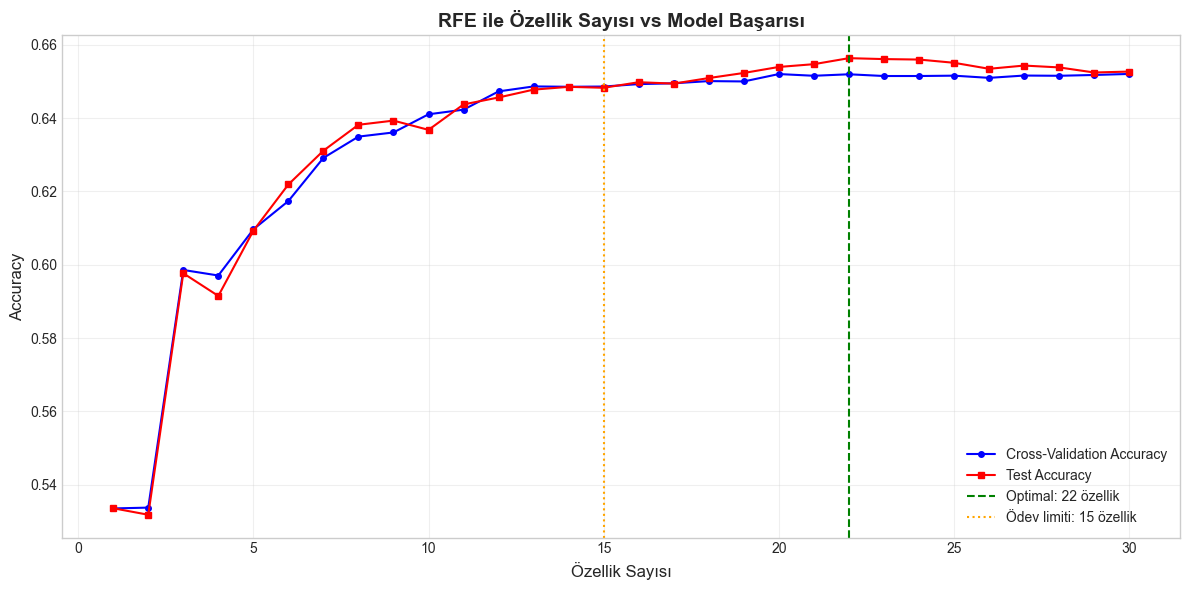


✓ Optimal özellik sayısı analiz grafiği kaydedildi.


In [38]:
# Özellik sayısı vs Accuracy grafiği
fig, ax = plt.subplots(figsize=(12, 6))

n_features_list = [r['n_features'] for r in optimal_search_results]
cv_accuracies = [r['cv_accuracy'] for r in optimal_search_results]
test_accuracies = [r['test_accuracy'] for r in optimal_search_results]

ax.plot(n_features_list, cv_accuracies, 'b-o', label='Cross-Validation Accuracy', markersize=4)
ax.plot(n_features_list, test_accuracies, 'r-s', label='Test Accuracy', markersize=4)
ax.axvline(x=optimal_n_features, color='green', linestyle='--', label=f'Optimal: {optimal_n_features} özellik')
ax.axvline(x=15, color='orange', linestyle=':', label='Ödev limiti: 15 özellik')

ax.set_xlabel('Özellik Sayısı', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('RFE ile Özellik Sayısı vs Model Başarısı', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{get_results_dir()}/optimal_feature_count_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Optimal özellik sayısı analiz grafiği kaydedildi.")


📋 Karışıklık Matrisi - RFE Optimal (22 özellik)

[[2214 1484]
 [1241 2990]]


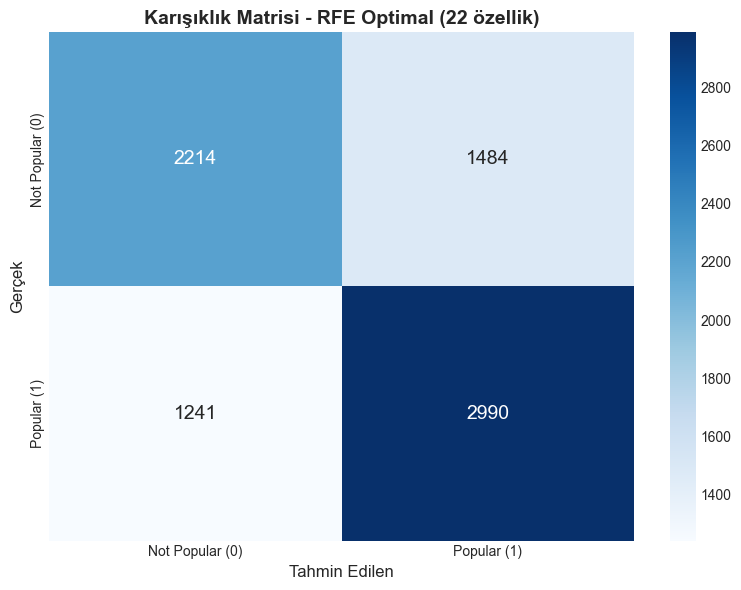

In [39]:
# Optimal RFE için karışıklık matrisi
cm_optimal = create_confusion_matrix(y_test_full, y_pred_optimal)

print(f"\n📋 Karışıklık Matrisi - RFE Optimal ({optimal_n_features} özellik)")
print("=" * 50)
print(f"\n{cm_optimal}")

fig = plot_confusion_matrix(
    cm_optimal, 
    title=f"Karışıklık Matrisi - RFE Optimal ({optimal_n_features} özellik)"
)
plt.savefig(f"{get_results_dir()}/optimal_rfe_confusion_matrix.png", dpi=150, bbox_inches='tight')
plt.show()

---
## 9. Güncellenmiş Sonuç Tablosu

In [40]:
# Güncellenmiş sonuç tablosu (optimal RFE dahil)
print("\n" + "=" * 90)
print("GÜNCELLENMİŞ SONUÇ TABLOSU (Optimal RFE Dahil)")
print("=" * 90)

final_results_df = pd.DataFrame([
    {
        'Yöntem': v['name'],
        'Özellik Sayısı': v['feature_count'],
        'Accuracy': f"{v['accuracy']:.4f}",
        'F1-Score': f"{v['f1_score']:.4f}",
        'Precision': f"{v['precision']:.4f}",
        'Recall': f"{v['recall']:.4f}"
    }
    for k, v in results.items()
])

display(final_results_df)


GÜNCELLENMİŞ SONUÇ TABLOSU (Optimal RFE Dahil)


,Yöntem,Özellik Sayısı,Accuracy,F1-Score,Precision,Recall
0,Tüm Özellikler,58,0.6552,0.6544,0.6544,0.6552
1,Filtreleme (Pearson),15,0.6431,0.6413,0.6421,0.6431
2,Sarmalayıcı (RFE),15,0.6510,0.6502,0.6502,0.6510
3,Gömülü (Random Forest),15,0.6278,0.6253,0.6266,0.6278
4,RFE Optimal (22 özellik),22,0.6563,0.6553,0.6555,0.6563


In [41]:
# Final sonuç tablosu (ödev formatında)
print("\n📋 ÖDEV SONUÇ TABLOSU (Güncellenmiş):\n")
print("| Yöntem | Özellik Sayısı | Doğruluk (Accuracy) | F1-Skoru |")
print("|--------|----------------|---------------------|----------|")

for key, result in results.items():
    print(f"| {result['name']} | {result['feature_count']} | {result['accuracy']:.4f} | {result['f1_score']:.4f} |")


📋 ÖDEV SONUÇ TABLOSU (Güncellenmiş):

| Yöntem | Özellik Sayısı | Doğruluk (Accuracy) | F1-Skoru |
|--------|----------------|---------------------|----------|
| Tüm Özellikler | 58 | 0.6552 | 0.6544 |
| Filtreleme (Pearson) | 15 | 0.6431 | 0.6413 |
| Sarmalayıcı (RFE) | 15 | 0.6510 | 0.6502 |
| Gömülü (Random Forest) | 15 | 0.6278 | 0.6253 |
| RFE Optimal (22 özellik) | 22 | 0.6563 | 0.6553 |


---
## 10. Yöntem Karşılaştırma Grafiği

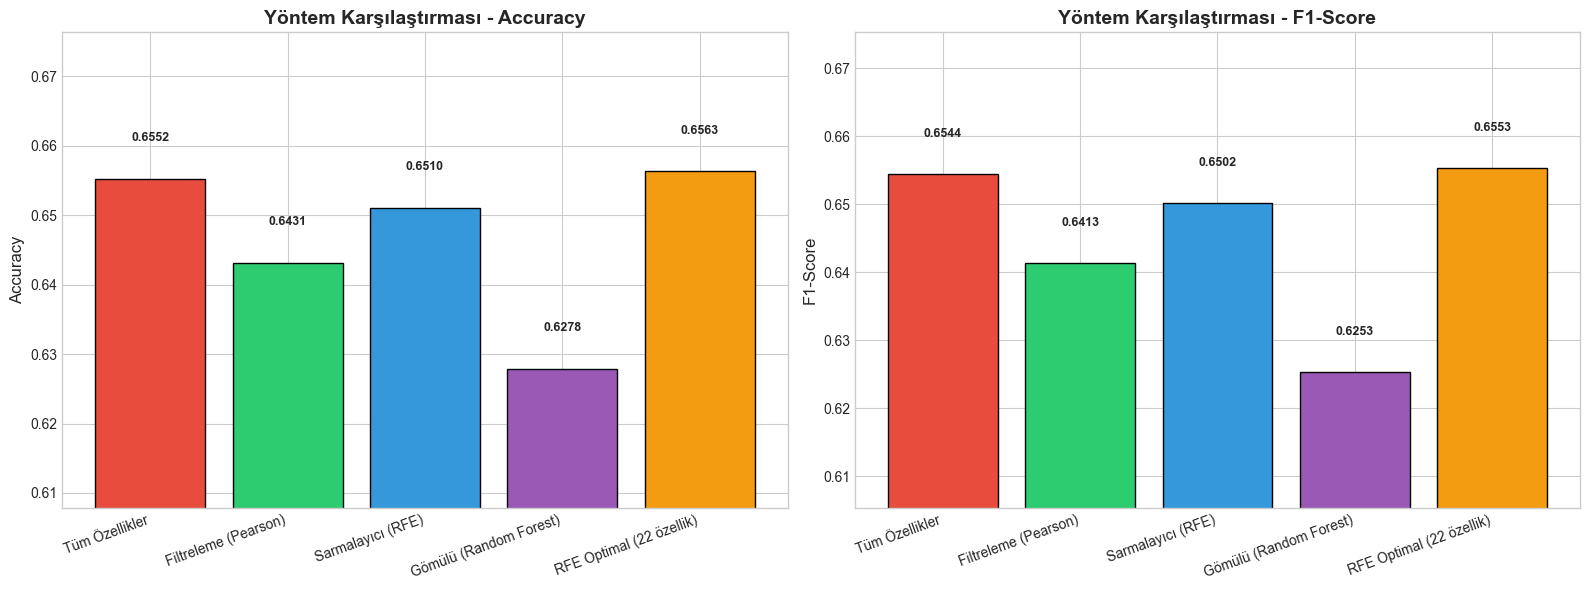


✓ Karşılaştırma grafiği kaydedildi.


In [42]:
# Accuracy karşılaştırma grafiği (TÜM YÖNTEMLER - optimal dahil)
methods = [r['name'] for r in results.values()]
accuracies = [r['accuracy'] for r in results.values()]
f1_scores = [r['f1_score'] for r in results.values()]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy grafiği
colors = ['#e74c3c', '#2ecc71', '#3498db', '#9b59b6', '#f39c12']
bars1 = axes[0].bar(range(len(methods)), accuracies, color=colors[:len(methods)], edgecolor='black')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Yöntem Karşılaştırması - Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(methods)))
axes[0].set_xticklabels(methods, rotation=20, ha='right')
axes[0].set_ylim([min(accuracies) - 0.02, max(accuracies) + 0.02])

for bar, val in zip(bars1, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                 f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# F1-Score grafiği
bars2 = axes[1].bar(range(len(methods)), f1_scores, color=colors[:len(methods)], edgecolor='black')
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('Yöntem Karşılaştırması - F1-Score', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(methods)))
axes[1].set_xticklabels(methods, rotation=20, ha='right')
axes[1].set_ylim([min(f1_scores) - 0.02, max(f1_scores) + 0.02])

for bar, val in zip(bars2, f1_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                 f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{get_results_dir()}/method_comparison_with_optimal.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Karşılaştırma grafiği kaydedildi.")

---
## 11. Markdown Raporu Oluştur

In [43]:
# Markdown raporu oluştur (TÜM YÖNTEMLER DAHİL)
best_cm = create_confusion_matrix(best_result['y_test'], best_result['y_pred'])

report = generate_markdown_report(
    results_dict=results,
    best_method=best_method_key,
    confusion_matrix_data=best_cm,
    overfitting_info=overfitting_info
)

# Raporu kaydet
results_dir = get_results_dir()
report_path = f"{results_dir}/evaluation_report.md"

with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report)

print(f"✓ Rapor kaydedildi: {report_path}")

✓ Rapor kaydedildi: c:\Users\kayra\OneDrive\Üniversite\Dersler\Doktora\Dönem 1\Makine Öğrenmesi\ödev2\kodlar\evaluate_performance\helpers\..\results/evaluation_report.md


---
## 12. Sonuç ve Yorumlar

In [44]:
print("=" * 80)
print("📝 SONUÇ VE DEĞERLENDİRME")
print("=" * 80)

print(f"""
Bu çalışmada, Online News Popularity veri kümesi üzerinde farklı özellik seçim
yöntemleri ile Lojistik Regresyon modeli eğitilmiş ve değerlendirilmiştir.

📊 ÖZET SONUÇLAR:
""")

# Sonuçları sırala
sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

for rank, (key, result) in enumerate(sorted_results, 1):
    emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    print(f"  {emoji} {rank}. {result['name']}")
    print(f"       Accuracy: {result['accuracy']:.4f}, F1: {result['f1_score']:.4f}, Özellik: {result['feature_count']}")

print(f"""
📌 ÖNEMLİ BULGULAR:

1. En yüksek başarı {sorted_results[0][1]['name']} ile elde edilmiştir.
   Accuracy: {sorted_results[0][1]['accuracy']:.4f}, F1-Score: {sorted_results[0][1]['f1_score']:.4f}

2. Özellik seçim yöntemleri arasında (Tüm Özellikler hariç) en başarılı:
   {best_result['name']} - Accuracy: {best_result['accuracy']:.4f}

3. RFE yöntemi ile optimal özellik sayısı: {optimal_n_features}
   Bu sayıda özellik ile Test Accuracy: {optimal_test_accuracy:.4f}

4. 5-fold cross validation ile model stabilitesi test edilmiştir.

5. Aşırı öğrenme durumunda regularization parametresi (C) ayarlanmıştır.
""")

print("\n" + "=" * 80)
print("✓ DEĞERLENDİRME TAMAMLANDI")
print("=" * 80)

📝 SONUÇ VE DEĞERLENDİRME

Bu çalışmada, Online News Popularity veri kümesi üzerinde farklı özellik seçim
yöntemleri ile Lojistik Regresyon modeli eğitilmiş ve değerlendirilmiştir.

📊 ÖZET SONUÇLAR:

  🥇 1. RFE Optimal (22 özellik)
       Accuracy: 0.6563, F1: 0.6553, Özellik: 22
  🥈 2. Tüm Özellikler
       Accuracy: 0.6552, F1: 0.6544, Özellik: 58
  🥉 3. Sarmalayıcı (RFE)
       Accuracy: 0.6510, F1: 0.6502, Özellik: 15
     4. Filtreleme (Pearson)
       Accuracy: 0.6431, F1: 0.6413, Özellik: 15
     5. Gömülü (Random Forest)
       Accuracy: 0.6278, F1: 0.6253, Özellik: 15

📌 ÖNEMLİ BULGULAR:

1. En yüksek başarı RFE Optimal (22 özellik) ile elde edilmiştir.
   Accuracy: 0.6563, F1-Score: 0.6553

2. Özellik seçim yöntemleri arasında (Tüm Özellikler hariç) en başarılı:
   Sarmalayıcı (RFE) - Accuracy: 0.6510

3. RFE yöntemi ile optimal özellik sayısı: 22
   Bu sayıda özellik ile Test Accuracy: 0.6563

4. 5-fold cross validation ile model stabilitesi test edilmiştir.

5. Aşırı öğrenme